In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import svm
import joblib
import optuna

In [33]:
df = pd.read_csv("consumo_casa.csv")

In [46]:
df = pd.read_csv("consumo_casa.csv")


df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Dia'] = df['Fecha'].dt.day
df['Hora'] = df['Fecha'].dt.hour
df['Minuto'] = df['Fecha'].dt.minute

del df['Unnamed: 0']
del df['Fecha']

columnas = df.columns.tolist()
ultimas_tres_columnas = columnas[-3:]
nuevas_columnas = ultimas_tres_columnas + columnas[:-3]
df = df[nuevas_columnas]

df.columns = df.columns.str.replace(' ', '')
df = df.rename(columns={'Medidor[W]': 'Medidor'})
df1 = df.iloc[:, :4] # Selecciona las dos primeras columnas
df2 = df.iloc[:, 4:] # Selecciona las columnas desde la tercera en adelante

In [52]:
df_filter = df[df["Dia"] == 5]
del df_filter["Dia"]
#del df_filter["Hora"]
del df_filter["Minuto"]
df_filter

,Hora,Medidor,Refrigerator,Clotheswasher,ClothesIron,Computer,Oven,Play,TV,Soundsystem
39909,0,93.241,0.0,0.9,1.4,0.0,1.1,0.0,0.2,4.3
39910,0,93.010,0.2,1.1,0.0,1.1,0.0,0.0,0.5,5.4
39911,0,91.201,1.1,0.2,0.0,1.1,0.0,1.4,1.1,4.6
39912,0,93.082,0.0,1.0,0.0,0.2,0.2,0.0,1.1,4.4
39913,0,94.901,0.0,0.2,0.1,0.7,1.3,1.1,1.1,5.9
...,...,...,...,...,...,...,...,...,...,...
170777,23,88.289,1.0,1.5,0.1,0.0,0.1,1.4,0.0,4.7
170778,23,87.276,1.0,0.0,0.1,0.0,0.2,0.3,0.9,5.4
170779,23,227.618,152.1,1.6,0.1,0.0,0.2,0.0,1.1,4.5
170780,23,214.345,152.1,0.3,1.3,0.0,0.2,0.0,1.1,4.7


In [56]:
plt.figure(figsize=(10, 6))

# Grafica cada serie temporal
for col in df_filter.columns:
    plt.plot(df_filter["Hora"], df_filter[col], label=col)

AttributeError: module 'matplotlib.pyplot' has no attribute 'lineplot'

<Figure size 1000x600 with 0 Axes>

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194123 entries, 0 to 194122
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Refrigerator   194123 non-null  float64
 1   Clotheswasher  194123 non-null  float64
 2   ClothesIron    194123 non-null  float64
 3   Computer       194123 non-null  float64
 4   Oven           194123 non-null  float64
 5   Play           194123 non-null  float64
 6   TV             194123 non-null  float64
 7   Soundsystem    194123 non-null  float64
dtypes: float64(8)
memory usage: 11.8 MB


In [38]:
df2.describe()

,Refrigerator,Clotheswasher,ClothesIron,Computer,Oven,Play,TV,Soundsystem
count,194123.000000,194123.000000,194123.000000,194123.000000,194123.000000,194123.000000,194123.000000,194123.000000
mean,57.508366,4.234783,4.541936,1.335831,5.688060,0.945553,9.977765,3.559746
std,71.010637,26.762249,61.315247,5.846712,88.430616,1.452993,22.978044,2.266801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900000
50%,1.200000,0.700000,0.200000,0.200000,0.200000,0.200000,0.200000,4.500000
75%,131.400000,1.300000,0.600000,1.000000,1.000000,1.100000,1.100000,5.400000
max,843.800000,547.800000,1120.900000,62.300000,1682.700000,70.900000,647.000000,73.600000


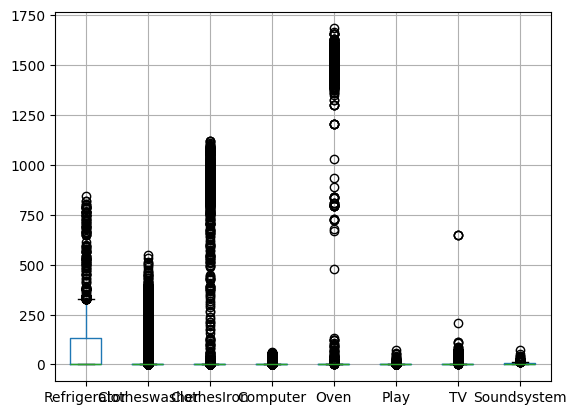

In [40]:
df.boxplot(column=['Refrigerator', 'Clotheswasher', 'ClothesIron', 'Computer', 'Oven', 'Play', 'TV', 'Soundsystem'])
plt.show()

In [42]:
df_melted = pd.melt(df2)

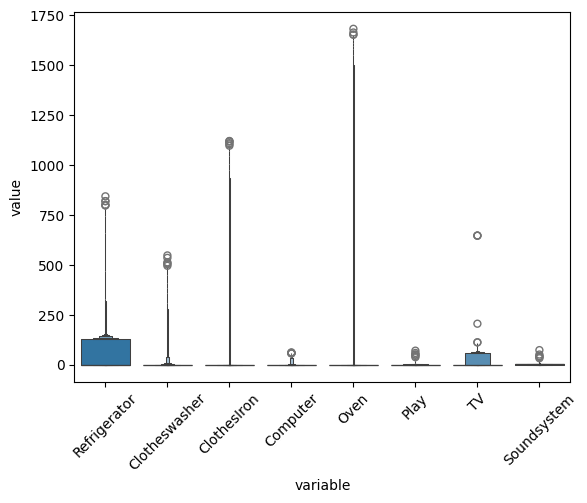

In [45]:
sns.boxenplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=45)
plt.show()

In [28]:
corr_matrix = df2.corr(method='pearson')
print(corr_matrix)

               Refrigerator  Clotheswasher  ClothesIron  Computer      Oven  \
Refrigerator       1.000000       0.006210     0.001767  0.006869  0.049601   
Clotheswasher      0.006210       1.000000    -0.000632  0.013673 -0.007634   
ClothesIron        0.001767      -0.000632     1.000000 -0.012057 -0.002498   
Computer           0.006869       0.013673    -0.012057  1.000000  0.007383   
Oven               0.049601      -0.007634    -0.002498  0.007383  1.000000   
Play               0.036700      -0.045398    -0.002140 -0.011896  0.036856   
TV                 0.056912      -0.040669    -0.021910 -0.030016  0.049486   
Soundsystem        0.002924      -0.006983     0.017903  0.080606  0.005508   

                   Play        TV  Soundsystem  
Refrigerator   0.036700  0.056912     0.002924  
Clotheswasher -0.045398 -0.040669    -0.006983  
ClothesIron   -0.002140 -0.021910     0.017903  
Computer      -0.011896 -0.030016     0.080606  
Oven           0.036856  0.049486     0.005

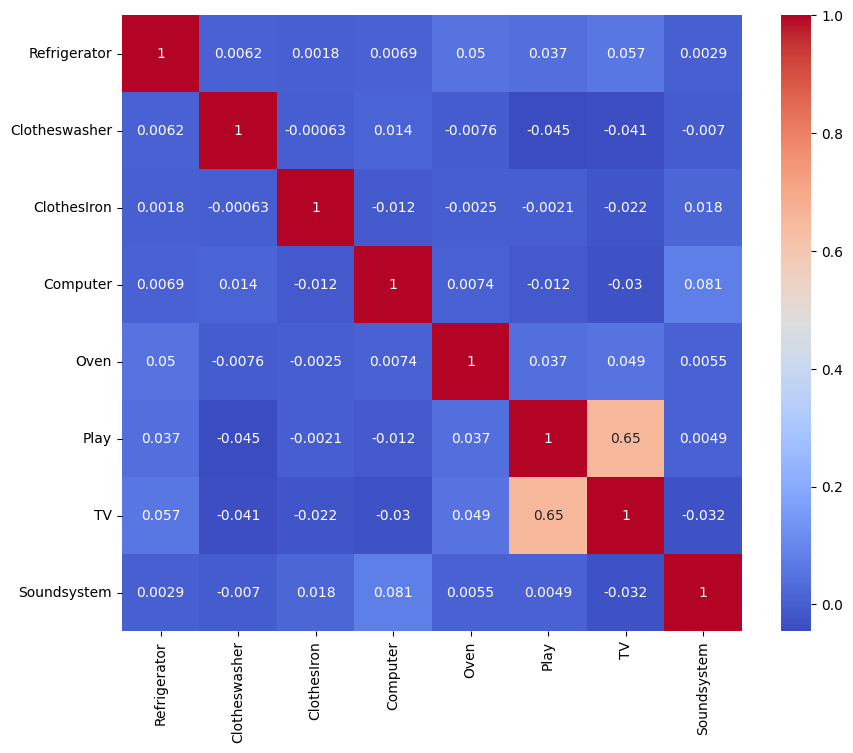

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

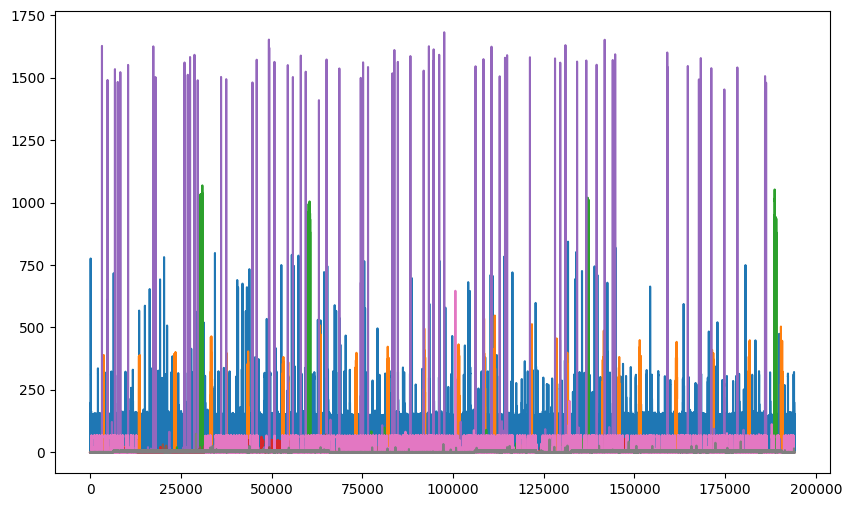

In [30]:
plt.figure(figsize=(10, 6))

# Grafica cada serie temporal
for col in df2.columns:
    plt.plot(df2.index, df2[col], label=col)

In [13]:
X = df1
y = df2.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 * 0.8 = 0.2

In [14]:
def modelosPorDispositivo(index):
    X = df1
    y = df2.iloc[:, index]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 * 0.8 = 0.2
    model_preds = []
    def fit_model(model, model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = round(r2_score(y_test, y_pred),4)
        adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
        mse = round(mean_squared_error(y_test, y_pred),4)
        mae = round(mean_absolute_error(y_test, y_pred),4)
        rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
        model_preds.append([model_name, r2, adj_r2, mse, mae, rmse])
        #print ("The R-Squared Value is: ", r2)
        #print ("Adjusted R-Squared Value is: ", adj_r2)
        #print("The Mean Squared error (MSE) is: ", mse)
        #print("Root Mean Squared Error (RMSE): ", rmse)
        #print("Mean Absolute Error (MAE) is: ", mae)

    def model_eval():
        preds = pd.DataFrame(model_preds)
        preds.columns = ["Mod_Name", "R2 Value", "adj_R2", "MSE", "RMSE", "MAE"]
        return preds.sort_values(by="R2 Value", ascending=False)

    print(f"DISPOSITIVO: {index}")
    # Regresion Lineal
    #print("Linear Regression")
    lr_model_freq = LinearRegression()
    lr_model_freq.fit(X_train, y_train)

    fit_model(lr_model_freq, "Linear Regression")

    ## Arbol de decision
    #print("Decision Tree")
    dectree_model_freq = DecisionTreeRegressor()
    fit_model(dectree_model_freq, "Decision Tree Regressor")

    ## Random Forest
    #print("Random Forest")
    randfor_model_freq = RandomForestRegressor()
    fit_model(randfor_model_freq, "Random Forest Regressor")

    ## XG Boost
    #print("XGBoost")
    XGB_model_freq = xgb.XGBRFRegressor()
    fit_model(XGB_model_freq, "XG Boost")

    print(model_eval())

In [25]:
for i in range(8):
    modelosPorDispositivo(i)

DISPOSITIVO: 0
                  Mod_Name  R2 Value  adj_R2        MSE     RMSE      MAE
2  Random Forest Regressor    0.8677  0.8677   675.4914   8.5102  25.9902
1  Decision Tree Regressor    0.7545  0.7545  1252.8700   9.2966  35.3959
3                 XG Boost    0.7357  0.7357  1349.0623  16.8845  36.7296
0        Linear Regression    0.0515  0.0515  4840.8760  63.3696  69.5764
DISPOSITIVO: 1
                  Mod_Name  R2 Value  adj_R2       MSE    RMSE      MAE
2  Random Forest Regressor    0.5547  0.5547  315.9699  3.3736  17.7755
3                 XG Boost    0.3671  0.3671  449.1014  4.7006  21.1920
1  Decision Tree Regressor    0.2239  0.2239  550.6552  3.5054  23.4660
0        Linear Regression    0.0008  0.0008  708.9930  6.7213  26.6269
DISPOSITIVO: 2
                  Mod_Name  R2 Value  adj_R2        MSE    RMSE      MAE
2  Random Forest Regressor    0.7594  0.7594   847.4490  2.3763  29.1110
1  Decision Tree Regressor    0.5757  0.5757  1494.5211  2.3265  38.6590
3     

In [15]:
def modelosPorDispositivo2(index):
    X = df1
    y = df2.iloc[:, index]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    #X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0) # 0.25 * 0.8 = 0.2
    Results = df1.copy()
    model_preds = []

    def objective_dtree(trial):
        max_depth = trial.suggest_int('max_depth', 2, 64)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
        
        # Cambiado a DecisionTreeRegressor
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Cambiado a r2_score para regresión
        r2 = mean_squared_error(y_test, y_pred)
        
        return r2

    sampler = optuna.samplers.TPESampler(seed=3535)
    study_dtree = optuna.create_study(sampler=sampler, direction='minimize')
    study_dtree.optimize(objective_dtree, n_trials=100)

    print(study_dtree.best_params)

    max_depth=study_dtree.best_params['max_depth']
    min_samples_leaf = study_dtree.best_params['min_samples_leaf']


        

    def fit_model(model, model_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = round(r2_score(y_test, y_pred),4)
        adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
        mse = round(mean_squared_error(y_test, y_pred),4)
        mae = round(mean_absolute_error(y_test, y_pred),4)
        rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
        model_preds.append([model_name, r2, adj_r2, mse, mae, rmse])
        #print ("The R-Squared Value is: ", r2)
        #print ("Adjusted R-Squared Value is: ", adj_r2)
        #print("The Mean Squared error (MSE) is: ", mse)
        #print("Root Mean Squared Error (RMSE): ", rmse)
        #print("Mean Absolute Error (MAE) is: ", mae)

    def model_eval():
        preds = pd.DataFrame(model_preds)
        preds.columns = ["Mod_Name", "R2 Value", "adj_R2", "MSE", "RMSE", "MAE"]
        return preds.sort_values(by="R2 Value", ascending=False)

    print(f"DISPOSITIVO: {index}")
    ## Random Forest
    #print("Random Forest")
    randfor_reg= DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    fit_model(randfor_reg, "Decision Tree")
    joblib.dump(randfor_reg, f'modelo_regDTN_d{index}.pkl')


    print(model_eval())

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def objective_dtree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 64)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    # Cambiado a DecisionTreeRegressor
    clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Cambiado a r2_score para regresión
    r2 = mean_squared_error(y_test, y_pred)
    
    return r2

sampler = optuna.samplers.TPESampler(seed=3535)
study_dtree = optuna.create_study(sampler=sampler, direction='minimize')
study_dtree.optimize(objective_dtree, n_trials=100)

[I 2024-04-14 06:37:46,920] A new study created in memory with name: no-name-ed708a9f-569a-4d96-8b20-cdcf66c634f5
[I 2024-04-14 06:37:47,866] Trial 0 finished with value: 919.3305992617461 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 919.3305992617461.
[I 2024-04-14 06:37:48,750] Trial 1 finished with value: 917.7464070458874 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:37:49,589] Trial 2 finished with value: 937.2990489267082 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:37:50,379] Trial 3 finished with value: 975.3063341018045 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:37:51,194] Trial 4 finished with value: 935.4854833755433 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 

In [16]:
for i in range(8):
    modelosPorDispositivo2(i)

[I 2024-04-14 06:45:13,549] A new study created in memory with name: no-name-203cc62d-8b82-420a-a7cf-696bf55db005


[I 2024-04-14 06:45:14,448] Trial 0 finished with value: 919.3305992617461 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 919.3305992617461.
[I 2024-04-14 06:45:15,319] Trial 1 finished with value: 917.7464070458874 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:45:16,190] Trial 2 finished with value: 937.2990489267082 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:45:17,025] Trial 3 finished with value: 975.3063341018045 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:45:17,818] Trial 4 finished with value: 935.4854833755433 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 917.7464070458874.
[I 2024-04-14 06:45:18,328] Trial 5 finished with value: 1039.065060220887 and parameters: {'ma

{'max_depth': 19, 'min_samples_leaf': 2}
DISPOSITIVO: 0


[I 2024-04-14 06:46:37,602] A new study created in memory with name: no-name-c20d0d1b-cac9-4372-96e2-9391f9fe19e4


        Mod_Name  R2 Value  adj_R2       MSE    RMSE      MAE
0  Decision Tree    0.8314  0.8314  860.2692  8.4776  29.3303


[I 2024-04-14 06:46:38,565] Trial 0 finished with value: 385.76836962217124 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 385.76836962217124.
[I 2024-04-14 06:46:39,339] Trial 1 finished with value: 386.35309622195825 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 0 with value: 385.76836962217124.
[I 2024-04-14 06:46:40,100] Trial 2 finished with value: 388.5194836789853 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 0 with value: 385.76836962217124.
[I 2024-04-14 06:46:40,797] Trial 3 finished with value: 403.5717294693431 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 0 with value: 385.76836962217124.
[I 2024-04-14 06:46:41,511] Trial 4 finished with value: 388.5863833992744 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 0 with value: 385.76836962217124.
[I 2024-04-14 06:46:41,982] Trial 5 finished with value: 409.2125780093991 and parameter

{'max_depth': 25, 'min_samples_leaf': 19}
DISPOSITIVO: 1


[I 2024-04-14 06:47:49,877] A new study created in memory with name: no-name-7515da15-59c0-4c00-a27d-964ecc4106e1


        Mod_Name  R2 Value  adj_R2       MSE    RMSE      MAE
0  Decision Tree      0.46    0.46  383.1297  3.7329  19.5737


[I 2024-04-14 06:47:50,795] Trial 0 finished with value: 1107.7901993163255 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 1107.7901993163255.
[I 2024-04-14 06:47:51,663] Trial 1 finished with value: 1112.9262192838319 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 0 with value: 1107.7901993163255.
[I 2024-04-14 06:47:52,523] Trial 2 finished with value: 1132.2767008595472 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 0 with value: 1107.7901993163255.
[I 2024-04-14 06:47:53,317] Trial 3 finished with value: 1237.8959510773248 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 0 with value: 1107.7901993163255.
[I 2024-04-14 06:47:54,083] Trial 4 finished with value: 1132.2691570282796 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 0 with value: 1107.7901993163255.
[I 2024-04-14 06:47:54,559] Trial 5 finished with value: 1184.2748587702108 and param

{'max_depth': 19, 'min_samples_leaf': 8}
DISPOSITIVO: 2


[I 2024-04-14 06:49:17,970] A new study created in memory with name: no-name-68ad2f22-3bc5-4f20-8234-64018ebab795


        Mod_Name  R2 Value  adj_R2        MSE    RMSE      MAE
0  Decision Tree    0.7048  0.7048  1039.9475  2.3968  32.2482


[I 2024-04-14 06:49:18,708] Trial 0 finished with value: 10.884441104288745 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 10.884441104288745.
[I 2024-04-14 06:49:19,440] Trial 1 finished with value: 10.686316367856435 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 10.686316367856435.
[I 2024-04-14 06:49:20,135] Trial 2 finished with value: 11.542600605006282 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 10.686316367856435.
[I 2024-04-14 06:49:20,776] Trial 3 finished with value: 12.88540666857758 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 10.686316367856435.
[I 2024-04-14 06:49:21,502] Trial 4 finished with value: 11.541251711539106 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 10.686316367856435.
[I 2024-04-14 06:49:21,976] Trial 5 finished with value: 16.68325363270771 and paramet

{'max_depth': 51, 'min_samples_leaf': 3}
DISPOSITIVO: 3


[I 2024-04-14 06:50:46,775] A new study created in memory with name: no-name-9230d616-9812-4b8a-9278-11f834a6ed00


        Mod_Name  R2 Value  adj_R2     MSE   RMSE     MAE
0  Decision Tree    0.7278  0.7278  8.8808  0.748  2.9801


[I 2024-04-14 06:50:47,885] Trial 0 finished with value: 2622.2781700479 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 2622.2781700479.
[I 2024-04-14 06:50:48,830] Trial 1 finished with value: 2602.9188860921004 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 2602.9188860921004.
[I 2024-04-14 06:50:49,816] Trial 2 finished with value: 2918.100104631023 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 2602.9188860921004.
[I 2024-04-14 06:50:50,721] Trial 3 finished with value: 3136.314131216028 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 2602.9188860921004.
[I 2024-04-14 06:50:51,643] Trial 4 finished with value: 2918.104425216882 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 2602.9188860921004.
[I 2024-04-14 06:50:52,154] Trial 5 finished with value: 2593.7157173199503 and parameters: {'

{'max_depth': 50, 'min_samples_leaf': 5}
DISPOSITIVO: 4


[I 2024-04-14 06:52:36,858] A new study created in memory with name: no-name-01d292f2-6797-44a8-8664-e50c035ff11a


        Mod_Name  R2 Value  adj_R2        MSE   RMSE      MAE
0  Decision Tree    0.7009  0.7009  2138.5152  2.905  46.2441


[I 2024-04-14 06:52:37,648] Trial 0 finished with value: 0.8219544235334797 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8219544235334797.
[I 2024-04-14 06:52:38,439] Trial 1 finished with value: 0.8162398934731266 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.8162398934731266.
[I 2024-04-14 06:52:39,164] Trial 2 finished with value: 0.830520132120408 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8162398934731266.
[I 2024-04-14 06:52:39,923] Trial 3 finished with value: 0.8735155045932455 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.8162398934731266.
[I 2024-04-14 06:52:40,762] Trial 4 finished with value: 0.8271477327805654 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8162398934731266.
[I 2024-04-14 06:52:41,291] Trial 5 finished with value: 0.9232840844196205 and parame

{'max_depth': 19, 'min_samples_leaf': 6}
DISPOSITIVO: 5


[I 2024-04-14 06:53:47,924] A new study created in memory with name: no-name-61faec7c-0d4f-4b67-b686-af2a637363fe


        Mod_Name  R2 Value  adj_R2     MSE    RMSE     MAE
0  Decision Tree    0.6093  0.6093  0.7886  0.5644  0.8881


[I 2024-04-14 06:53:48,725] Trial 0 finished with value: 144.60215933257282 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 144.60215933257282.
[I 2024-04-14 06:53:49,505] Trial 1 finished with value: 143.0599232964129 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 143.0599232964129.
[I 2024-04-14 06:53:50,257] Trial 2 finished with value: 149.61408654211166 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 143.0599232964129.
[I 2024-04-14 06:53:50,956] Trial 3 finished with value: 167.407173304082 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 143.0599232964129.
[I 2024-04-14 06:53:51,669] Trial 4 finished with value: 149.71508410034147 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 143.0599232964129.
[I 2024-04-14 06:53:52,145] Trial 5 finished with value: 187.75100358849036 and parameters: 

{'max_depth': 34, 'min_samples_leaf': 7}
DISPOSITIVO: 6


[I 2024-04-14 06:55:14,775] A new study created in memory with name: no-name-dced2303-323c-4cb8-9f21-187bd288301d


        Mod_Name  R2 Value  adj_R2       MSE   RMSE      MAE
0  Decision Tree    0.7552  0.7552  130.4138  3.563  11.4199


[I 2024-04-14 06:55:15,564] Trial 0 finished with value: 2.781220040402135 and parameters: {'max_depth': 62, 'min_samples_leaf': 13}. Best is trial 0 with value: 2.781220040402135.
[I 2024-04-14 06:55:16,353] Trial 1 finished with value: 2.765981650602647 and parameters: {'max_depth': 24, 'min_samples_leaf': 12}. Best is trial 1 with value: 2.765981650602647.
[I 2024-04-14 06:55:17,098] Trial 2 finished with value: 2.8370047734734785 and parameters: {'max_depth': 34, 'min_samples_leaf': 17}. Best is trial 1 with value: 2.765981650602647.
[I 2024-04-14 06:55:17,790] Trial 3 finished with value: 2.959384451977376 and parameters: {'max_depth': 63, 'min_samples_leaf': 30}. Best is trial 1 with value: 2.765981650602647.
[I 2024-04-14 06:55:18,510] Trial 4 finished with value: 2.8331311432450175 and parameters: {'max_depth': 21, 'min_samples_leaf': 17}. Best is trial 1 with value: 2.765981650602647.
[I 2024-04-14 06:55:18,998] Trial 5 finished with value: 3.5901595899736862 and parameters: {

{'max_depth': 21, 'min_samples_leaf': 6}
DISPOSITIVO: 7
        Mod_Name  R2 Value  adj_R2     MSE   RMSE     MAE
0  Decision Tree    0.4677  0.4677  2.7021  1.118  1.6438


In [7]:
df = pd.read_csv("consumo_casa.csv")


df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Dia'] = df['Fecha'].dt.day
df['Hora'] = df['Fecha'].dt.hour
df['Minuto'] = df['Fecha'].dt.minute

del df['Unnamed: 0']
#del df['Fecha']

columnas = df.columns.tolist()
ultimas_tres_columnas = columnas[-3:]
print(columnas[0])
nuevas_columnas = [columnas[0]] + ultimas_tres_columnas + columnas[1:-3]
df = df[nuevas_columnas]

df.columns = df.columns.str.replace(' ', '')
df = df.rename(columns={'Medidor[W]': 'Medidor'})
df1 = df.iloc[:, :5] # Selecciona las dos primeras columnas
df2 = df.iloc[:, 5:] # Selecciona las columnas desde la tercera en adelante
df1

Fecha


,Fecha,Dia,Hora,Minuto,Medidor
0,2017-06-07 00:00:00,7,0,0,228.887
1,2017-06-07 00:01:00,7,0,1,231.814
2,2017-06-07 00:02:00,7,0,2,230.971
3,2017-06-07 00:03:00,7,0,3,231.878
4,2017-06-07 00:04:00,7,0,4,189.225
...,...,...,...,...,...
194118,2017-10-22 23:55:00,22,23,55,88.272
194119,2017-10-22 23:56:00,22,23,56,86.386
194120,2017-10-22 23:57:00,22,23,57,85.766
194121,2017-10-22 23:58:00,22,23,58,87.665


In [8]:
dfResultR = df1.copy()
dfResultR

,Fecha,Dia,Hora,Minuto,Medidor
0,2017-06-07 00:00:00,7,0,0,228.887
1,2017-06-07 00:01:00,7,0,1,231.814
2,2017-06-07 00:02:00,7,0,2,230.971
3,2017-06-07 00:03:00,7,0,3,231.878
4,2017-06-07 00:04:00,7,0,4,189.225
...,...,...,...,...,...
194118,2017-10-22 23:55:00,22,23,55,88.272
194119,2017-10-22 23:56:00,22,23,56,86.386
194120,2017-10-22 23:57:00,22,23,57,85.766
194121,2017-10-22 23:58:00,22,23,58,87.665


In [11]:
df2

,Refrigerator,Clotheswasher,ClothesIron,Computer,Oven,Play,TV,Soundsystem
0,134.6,1.0,0.0,0.3,0.1,0.0,0.0,0.1
1,134.6,0.2,0.0,0.3,0.2,0.0,0.0,0.1
2,131.3,0.3,0.0,0.3,0.0,0.0,0.0,1.0
3,131.3,0.0,0.5,0.1,0.0,1.1,0.1,1.0
4,0.0,0.1,0.0,0.0,0.1,0.0,0.6,0.1
...,...,...,...,...,...,...,...,...
194118,0.1,1.4,0.0,0.0,0.8,0.4,0.2,0.4
194119,1.0,1.3,0.1,0.0,1.0,1.3,1.0,0.6
194120,0.0,1.8,0.1,0.0,0.1,0.1,1.0,0.6
194121,0.4,0.0,0.1,0.0,0.4,0.1,1.1,1.0


In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

In [15]:
X = df1.iloc[:,1:]
def predicciones(X):
    for i in range(8):
        y_pred = modelosR[f"modc{i}"].predict(X)
        dfResultR[f"Dispositivo{i}"] = y_pred
        y_test = df2.iloc[:,i]
        r2 = round(r2_score(y_test, y_pred),4)
        adj_r2 = round(1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1),4)
        mse = round(mean_squared_error(y_test, y_pred),4)
        mae = round(mean_absolute_error(y_test, y_pred),4)
        rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
        print ("The R-Squared Value is: ", r2)
        print ("Adjusted R-Squared Value is: ", adj_r2)
        print("The Mean Squared error (MSE) is: ", mse)
        print("Root Mean Squared Error (RMSE): ", rmse)
        print("Mean Absolute Error (MAE) is: ", mae)
        
        

In [16]:
predicciones(X)
dfResultR

The R-Squared Value is:  0.9619
Adjusted R-Squared Value is:  0.9619
The Mean Squared error (MSE) is:  191.98
Root Mean Squared Error (RMSE):  13.8557
Mean Absolute Error (MAE) is:  3.919
The R-Squared Value is:  0.8683
Adjusted R-Squared Value is:  0.8683
The Mean Squared error (MSE) is:  94.2922
Root Mean Squared Error (RMSE):  9.7104
Mean Absolute Error (MAE) is:  1.6234
The R-Squared Value is:  0.9374
Adjusted R-Squared Value is:  0.9374
The Mean Squared error (MSE) is:  235.3988
Root Mean Squared Error (RMSE):  15.3427
Mean Absolute Error (MAE) is:  1.0667
The R-Squared Value is:  0.9436
Adjusted R-Squared Value is:  0.9436
The Mean Squared error (MSE) is:  1.9287
Root Mean Squared Error (RMSE):  1.3888
Mean Absolute Error (MAE) is:  0.3595
The R-Squared Value is:  0.942
Adjusted R-Squared Value is:  0.942
The Mean Squared error (MSE) is:  453.8294
Root Mean Squared Error (RMSE):  21.3033
Mean Absolute Error (MAE) is:  1.3034
The R-Squared Value is:  0.9052
Adjusted R-Squared Valu

,Fecha,Dia,Hora,Minuto,Medidor,Dispositivo0,Dispositivo1,Dispositivo2,Dispositivo3,Dispositivo4,Dispositivo5,Dispositivo6,Dispositivo7
0,2017-06-07 00:00:00,7,0,0,228.887,135.145,0.879,0.165,0.286,0.263,0.165,0.107,0.852
1,2017-06-07 00:01:00,7,0,1,231.814,133.804,0.353,0.144,0.259,0.229,0.195,0.653,0.597
2,2017-06-07 00:02:00,7,0,2,230.971,130.035,0.477,0.104,0.269,0.106,0.071,1.916,1.172
3,2017-06-07 00:03:00,7,0,3,231.878,132.440,0.328,0.414,0.150,0.073,0.806,0.147,1.201
4,2017-06-07 00:04:00,7,0,4,189.225,0.332,0.383,0.167,0.111,0.197,0.076,0.580,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194118,2017-10-22 23:55:00,22,23,55,88.272,0.855,0.732,0.106,0.447,0.316,0.323,0.362,4.996
194119,2017-10-22 23:56:00,22,23,56,86.386,0.785,1.149,0.196,0.165,0.766,1.049,0.744,0.894
194120,2017-10-22 23:57:00,22,23,57,85.766,0.300,1.024,0.254,0.505,0.387,0.584,0.528,0.946
194121,2017-10-22 23:58:00,22,23,58,87.665,0.504,0.318,0.140,0.237,0.317,0.195,0.761,2.340
